In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob
from tqdm import tqdm

from ase.io.trajectory import Trajectory

from abtem import Potential, Waves, PlaneWave, CTF
from abtem.transfer import scherzer_defocus
from abtem.noise import poisson_noise
from abtem.mtf import MTF
from skimage.filters import gaussian

In [2]:
N = 1000
sampling = 0.05
L = sampling*N

atoms = Trajectory('trajectory_data/initial.traj')[0]
atoms.set_cell((L,L,L))
atoms.center()

wave_xy = np.asarray(atoms.cell[0,0], atoms.cell[1,1])
wave_pts = int(wave_xy/sampling)

potential = Potential(atoms,
              sampling=sampling,
              gpts=wave_pts,
              parametrization='kirkland',
              projection='infinite')
# Build wave
wave = PlaneWave(
        energy=50e3     #acceleration voltage in eV
)
# Compute exit wave
iexitwave = wave.multislice(potential,pbar=True)

Potential:   0%|          | 0/100 [00:00<?, ?it/s]

Multislice:   0%|          | 0/100 [00:00<?, ?it/s]

In [3]:
fpwave_files = glob.glob('../../simulation_data/fphotMoS2/wave/*')
mdwave_files = glob.glob('../../simulation_data/mdhotMoS2/wave/*')

In [4]:
fpwaves = []
for wf in tqdm(fpwave_files):
    fpwave = Waves.read(wf)
    fpwaves.append(fpwave.array[0])
fpwaves = np.asarray(fpwaves)

mdwaves = []
for wf in tqdm(mdwave_files[len(fpwaves)+1:]):
    mdwave = Waves.read(wf)
    mdwaves.append(mdwave.array[0])
mdwaves = np.asarray(mdwaves)

100%|██████████| 2500/2500 [03:06<00:00, 13.40it/s]


In [5]:
print(fpwaves.shape)
print(mdwaves.shape)

(2500, 1000, 1000)
(2500, 1000, 1000)


In [6]:
fpexitwaves = Waves(fpwaves[:],
                    extent=fpwave.extent,
                    energy=fpwave.energy,
                    antialias_aperture=(2 / 3.,) * 2)
mdexitwaves = Waves(mdwaves[:],
                    extent=mdwave.extent,
                    energy=mdwave.energy,
                    antialias_aperture=(2 / 3.,) * 2)

Scherzer Defocus: <function scherzer_defocus at 0x7f5ed9536550> Å


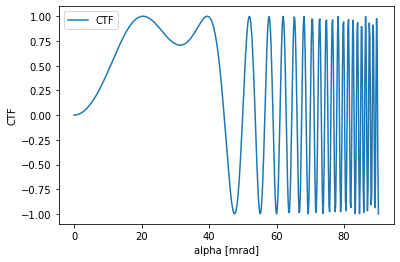

In [7]:
# See coefficients here
# https://abtem.readthedocs.io/en/latest/walkthrough/05_contrast_transfer_function.html
Cs = 8300*10 # Spherical abberation in Å
ctf = CTF(
    Cs=Cs,
    energy = mdwave.energy
)
ctf.defocus = scherzer_defocus(Cs, mdwave.energy) # Optimal defocus based on Cs and wavelength
print('Scherzer Defocus: {} Å'.format(scherzer_defocus))

ctf.show(90)
plt.show()

In [8]:
iimagewave = iexitwave.apply_ctf(ctf)
fpimagewaves = fpexitwaves.apply_ctf(ctf)
mdimagewaves = mdexitwaves.apply_ctf(ctf)

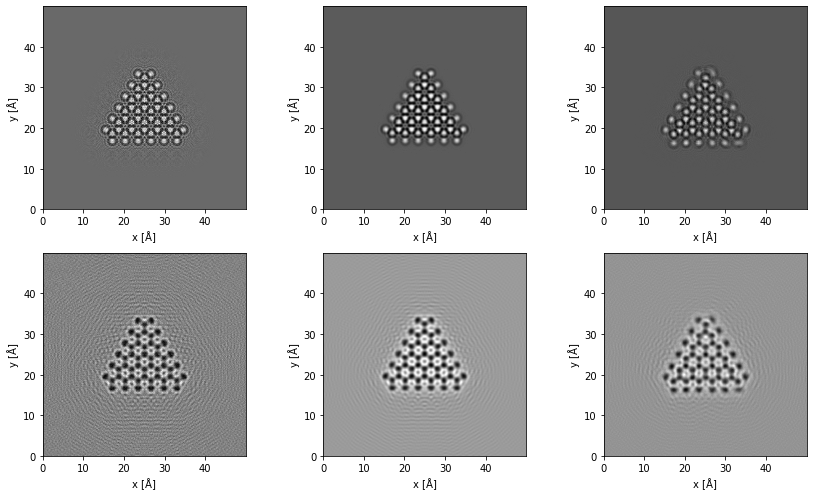

In [9]:
fig, ax = plt.subplots(figsize=(12.0,7.0),nrows=2,ncols=3)
iexitwave.intensity().show(ax=ax[0,0])
fpexitwaves.intensity().mean(0).show(ax=ax[0,1])
mdexitwaves.intensity().mean(0).show(ax=ax[0,2])
iimagewave.intensity().show(ax=ax[1,0])
fpimagewaves.intensity().mean(0).show(ax=ax[1,1])
mdimagewaves.intensity().mean(0).show(ax=ax[1,2])

plt.tight_layout()
plt.show()

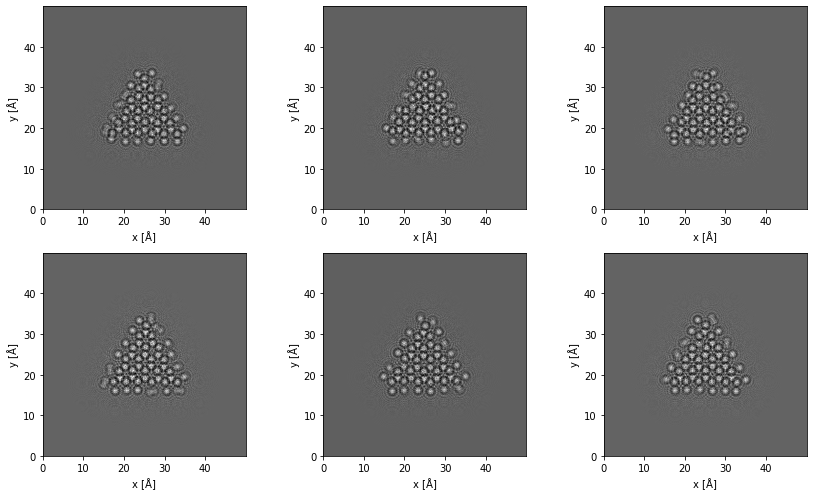

In [10]:
fig, ax = plt.subplots(figsize=(12.0,7.0),nrows=2,ncols=3)
fpexitwaves.intensity()[0].show(ax=ax[0,0])
fpexitwaves.intensity()[int(len(fpexitwaves)/2)].show(ax=ax[0,1])
fpexitwaves.intensity()[-1].show(ax=ax[0,2])
mdexitwaves.intensity()[0].show(ax=ax[1,0])
mdexitwaves.intensity()[int(len(mdexitwaves)/2)].show(ax=ax[1,1])
mdexitwaves.intensity()[-1].show(ax=ax[1,2])

plt.tight_layout()
plt.show()

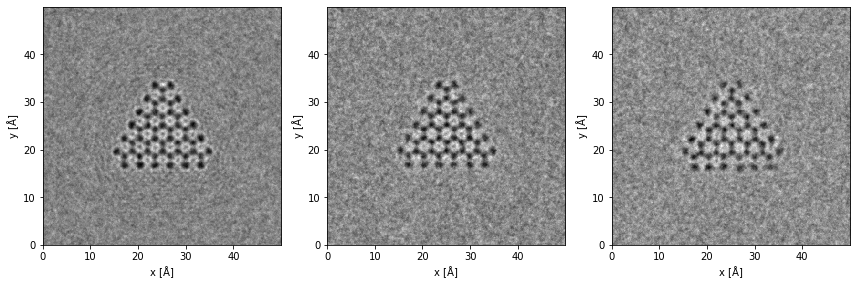

In [11]:
resample = 0.1    # Angstrom/pixel for detector resolution
dose = 1*10**3      # electrons/Angstrom squared for noise
mtf_parameters = {
  'c0': 1.0,
  'c1': 0.05,
  'c2': 0.45,
  'c3': 2.5
}
blur = 0.5

fig = plt.figure(figsize=(12,12))
for i, measurement_raw in enumerate([ iimagewave.intensity(), fpimagewaves.intensity().mean(0), mdimagewaves.intensity().mean(0) ]):
    # Add noise to image
    measurement_noise = poisson_noise(measurement_raw, dose)

    # Apply MTF
    mtf = MTF(**mtf_parameters)
    measurement_MTF = mtf(measurement_noise)

    # Add gaussian blur
    measurement = measurement_MTF.copy()
    array = measurement.array
    measurement.array[:] = gaussian(array,blur)
    
    # Resample to match experimental
    measurement = measurement.squeeze() # Removes 0 dimension (be careful when doing frozen phonon)
    measurement = measurement.interpolate(resample)
    
    ax = fig.add_subplot(1,3,i+1)
    measurement.show(ax=ax)
plt.tight_layout()
plt.show()